# GENIE3

In [4]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3
from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

650

In [6]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [7]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 1 genes.
startin QC
Seeing 10066 outliers (94.15% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [12]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:NUM_CELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']
metrics = {}

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 519.82 seconds
precision:  0.021422778298831015 
recall:  0.9666499130908254 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:07<00:00, 18.04it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:07<00:00, 16.02it/s]


Average Precision (AP):  0.0365440495693676
Area Under Precision-Recall Curve (AUPRC):  0.03560913943485749
EPR: 3.510842806084057


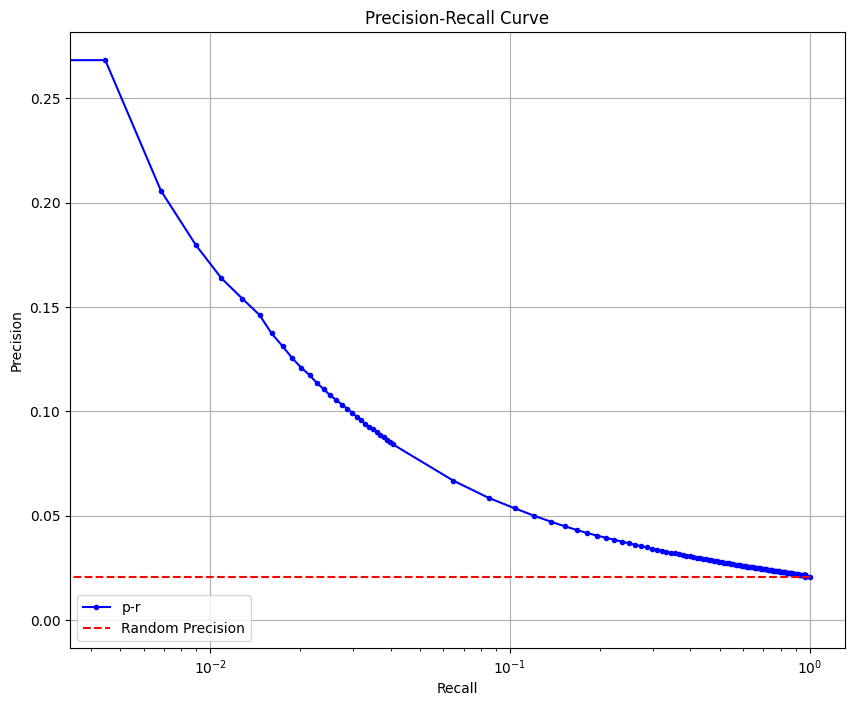

In [6]:
# normal
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 483.72 seconds
precision:  0.02143034966162402 
recall:  0.9668628231171424 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:05<00:00, 22.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 21.87it/s]


Average Precision (AP):  0.03644493614175813
Area Under Precision-Recall Curve (AUPRC):  0.03549047576584052
EPR: 3.519534225621074


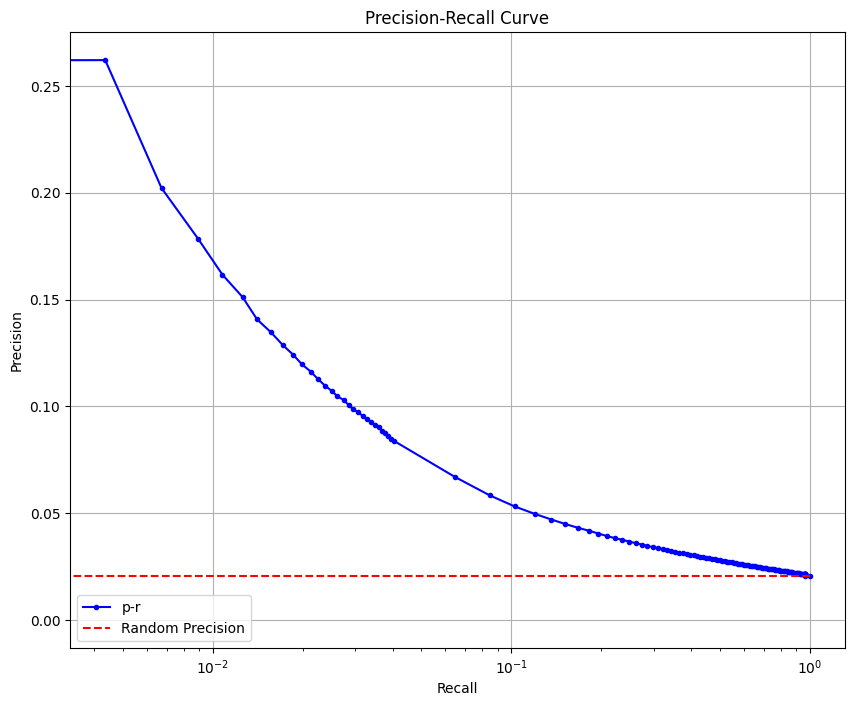

In [11]:
# normal
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

Tree method: RF
K: sqrt
Number of trees: 1000


running jobs on 20 threads
Elapsed time: 4834.61 seconds
precision:  0.02054756876753927 
recall:  0.9917314122566369 
random precision: 0.020718126571001305


 99%|█████████▉| 127/128 [00:07<00:00, 18.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:07<00:00, 16.46it/s]


Average Precision (AP):  0.042762162297311876
Area Under Precision-Recall Curve (AUPRC):  0.04136602724186575
EPR: 4.242502700502977


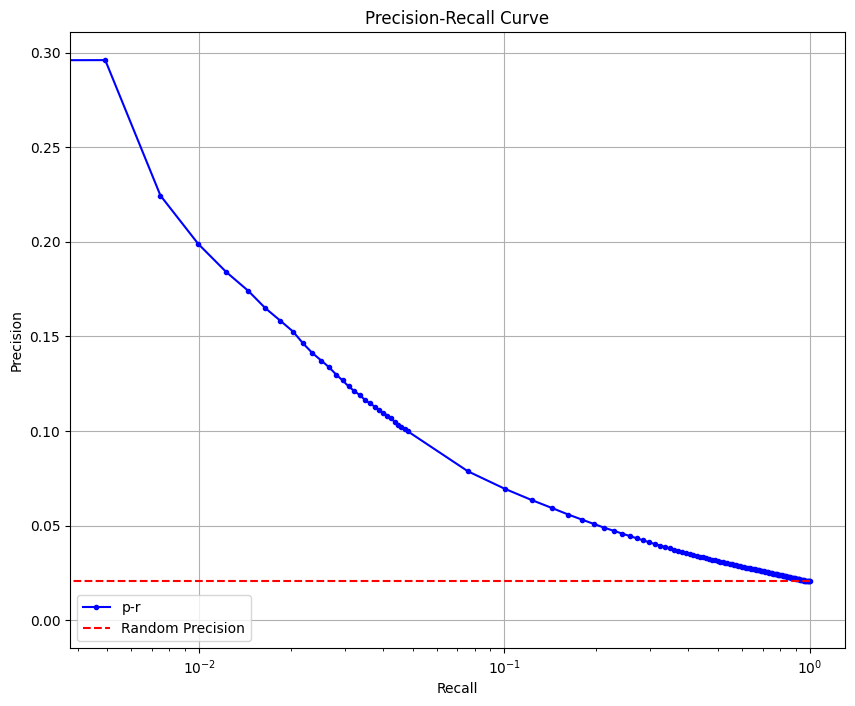

In [ ]:
# using more trees 10x = 20% improvement
genie_grn = compute_genie3(subadata, nthreads=20, ntrees=1000)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 9338.37 seconds
precision:  0.020546954612416655 
recall:  0.9917349025849371 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:05<00:00, 21.44it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 21.72it/s]


Average Precision (AP):  0.0473789398361116
Area Under Precision-Recall Curve (AUPRC):  0.04622458156725712
EPR: 5.362974145843862


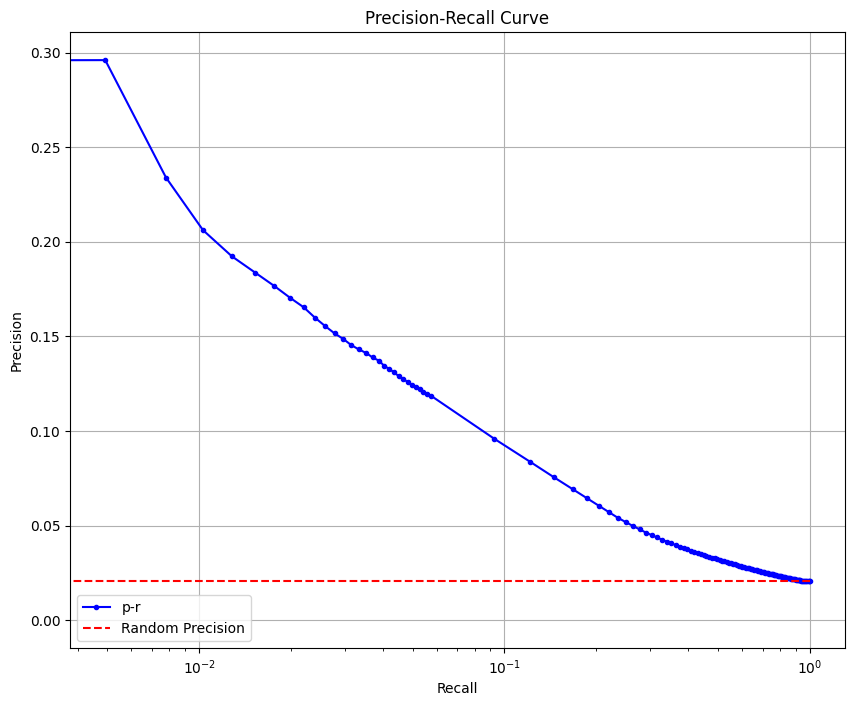

NameError: name 'metrics' is not defined

In [6]:
# Using more cells 10x = 40% improvement
subadata = adata[:10_000, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']
genie_grn = compute_genie3(subadata, nthreads=20, ntrees=100)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


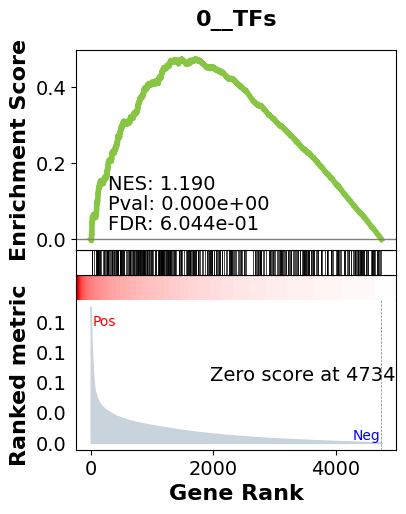

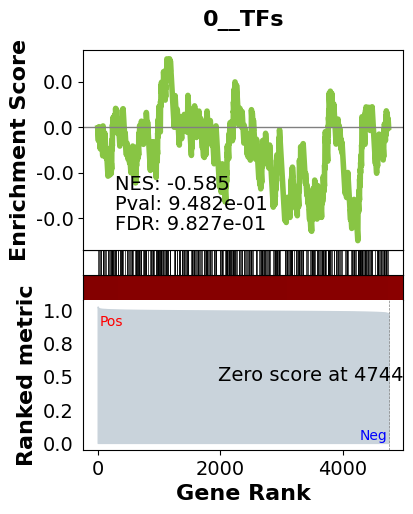

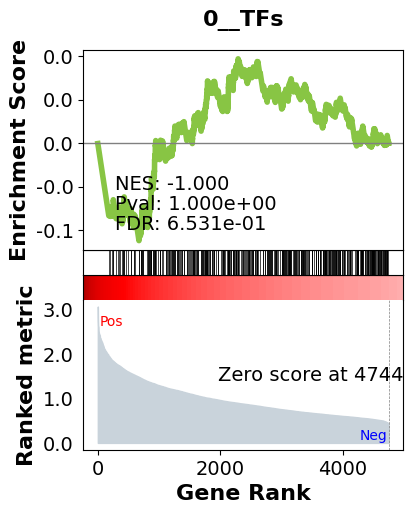

_________________________________________
TF specific enrichment
found some significant results for  17.857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.0016569776573904739 
recall:  0.9688489664305867 
random precision: 0.0016326385571186594


 99%|█████████▉| 127/128 [00:03<00:00, 47.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 32.75it/s]


Average Precision (AP):  0.00203317523175901
Area Under Precision-Recall Curve (AUPRC):  0.0019353272242568634
EPR: 5.620289492244857


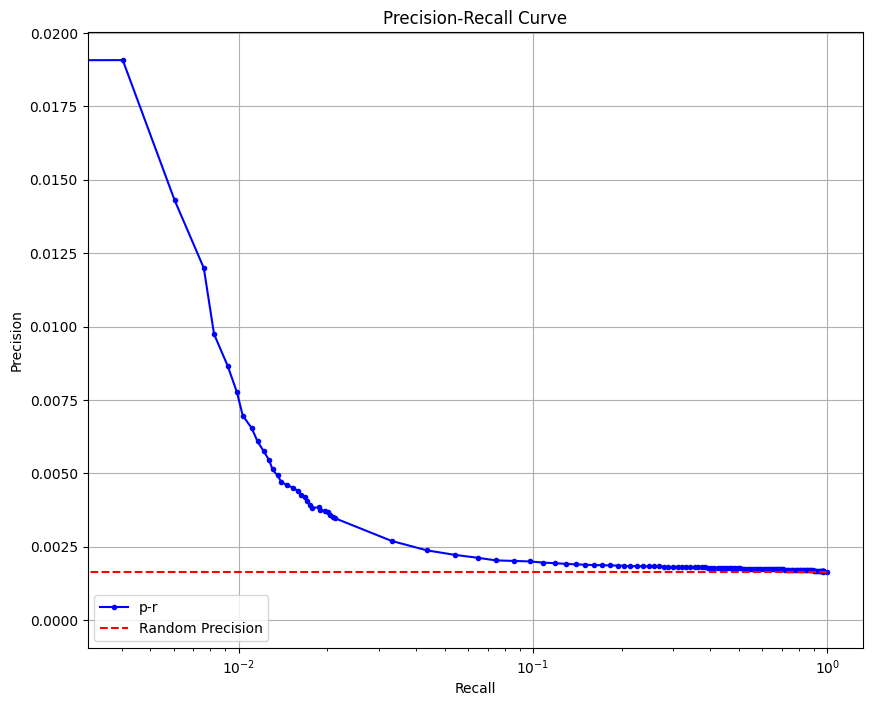

In [19]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 138.46 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


precision:  0.015117794580555307 
recall:  0.9900166389351082 
random precision: 0.015270228559383281


 84%|████████▎ | 107/128 [00:00<00:00, 203.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 199.88it/s]


Average Precision (AP):  0.023094831064819594
Area Under Precision-Recall Curve (AUPRC):  0.02309677114333527
EPR: 3.0305855196152924


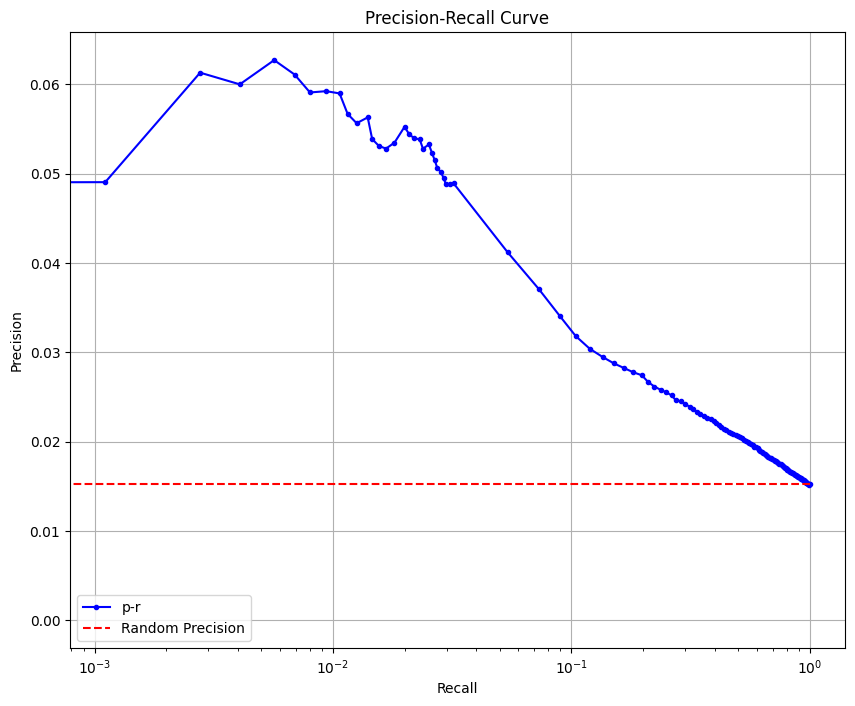

In [7]:
genie_grn = compute_genie3(subadata, nthreads=20,
                           regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = subadata.var.index
non_tf_mask = ~adata.var['isTF'].values
adata.varp['GRN'][non_tf_mask, :] = 0
metrics['genie3_tf_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment


Top central genes: []


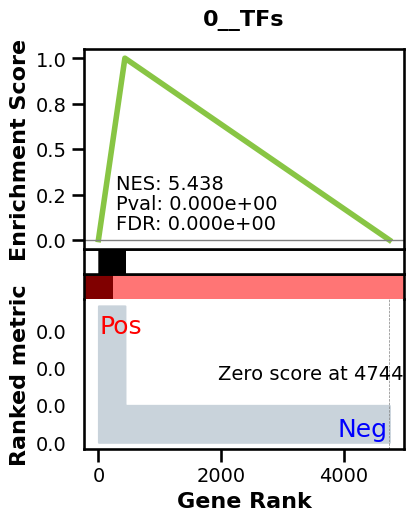

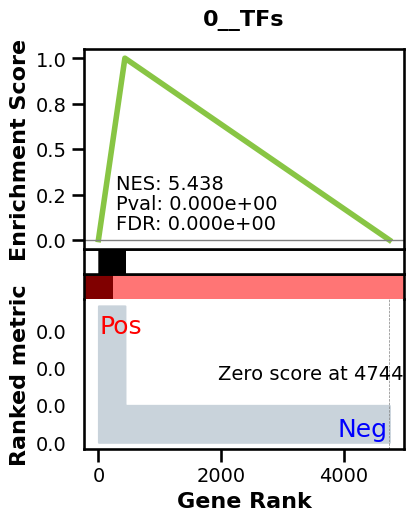

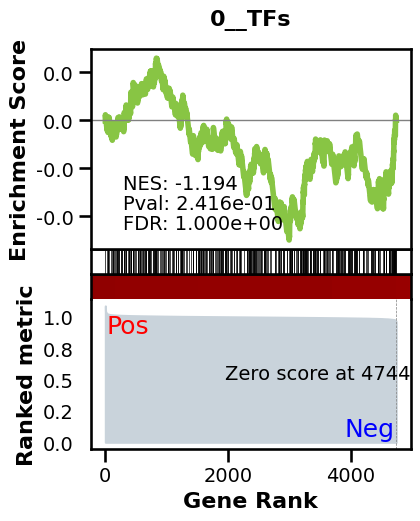

_________________________________________
TF specific enrichment


found some significant results for  5.357142857142857 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.008115454691164588 
recall:  0.5714285714285714 
random precision: 0.0016326385571186594



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.83it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.28it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.44it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.47it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.58it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.64it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.72it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.78it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.75it/s]


 47%|████▋     | 60/128 [00:01<00:01, 52.74it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.75it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.75it/s]


 61%|██████    | 78/128 [00:01<00:00, 52.74it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.84it/s]


 70%|███████   | 90/128 [00:01<00:00, 52.88it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 52.87it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 52.87it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 52.84it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 52.66it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 52.67it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 52.66it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:02<00:00, 52.67it/s]

Area Under Precision-Recall Curve (AUPRC):  0.00818330800021221
EPR: 17.297946276803675


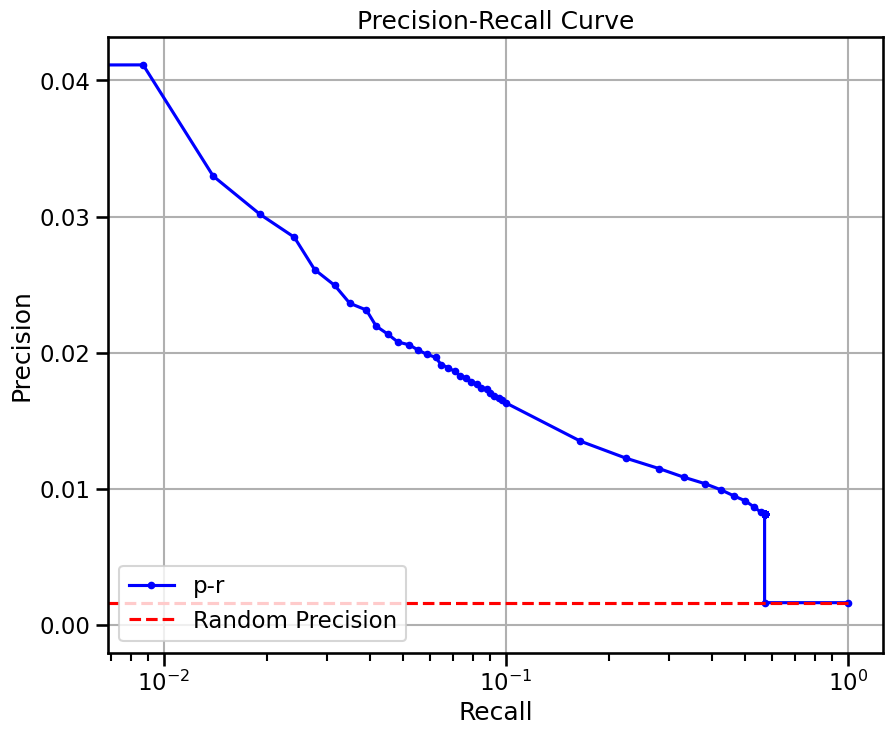

In [10]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_tf_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

In [11]:
metrics

{'genie3_perturb': {'precision': 0.021411638790563244,
  'recall': 0.9659762797288713,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.03565161597739377,
  'epr': 3.54075467253788},
 'genie3_perturb_base': {'TF_enr': True,
  'significant_enriched_TFtargets': 19.642857142857142,
  'precision': 0.0016940474499637448,
  'recall': 0.9264697414636955,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.0018857828449403108,
  'epr': 3.988476397763414},
 'genie3_tf_perturb': {'precision': 0.015117823033483179,
  'recall': 0.05607212414399698,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.020825095462878654,
  'epr': 1.0667829823965929},
 'genie3_tf_perturb_base': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Enteric neurons',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Tuft cells',
   'celltype.gmt__Satellite cells',
   'celltype.gmt__Radial glial cells'],
  'TF_enr': True,
  'significant_enriched_TFtargets': 5.3

In [12]:
import pandas as pd

In [13]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,3.540755,0.035652,0.020718,False
1,perturb,1.066783,0.020825,0.020718,True


In [14]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,3.988476,0.001886,0.001633,19.642857,True,False
1,perturb,17.297946,0.008183,0.001633,5.357143,True,True
